# SmartDynamic: Demand Forecasting Models

This notebook implements different demand forecasting models for the SmartDynamic pricing system. We'll develop and compare multiple approaches including statistical models, machine learning models, and deep learning techniques to predict product demand.

## Objectives
- Develop time series forecasting models using Prophet
- Implement LSTM-based deep learning models
- Create XGBoost regression models
- Compare model performance
- Evaluate models on different product categories
- Integrate external factors like weather and events

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys
import joblib
import warnings

# Machine learning and time series libraries
from prophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Add parent directory to path to enable imports from src
sys.path.append('..')

c:\Users\vaibh\PROJECTS\Data Science\Smart Dynamic Pricing System\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Prepare Data

First, we'll load the product data and prepare it for forecasting models.

In [2]:
# Load product data
product_data_path = '../data/sample_product_data.csv'
products_df = pd.read_csv(product_data_path)

# Convert date to datetime
products_df['date'] = pd.to_datetime(products_df['date'])
products_df = products_df.sort_values('date')

# Load weather data for context features
weather_data_path = '../data/weather_events_data.csv'
weather_df = pd.read_csv(weather_data_path)
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Merge product data with New York weather data
ny_weather = weather_df[weather_df['location'] == 'New York']
merged_df = pd.merge(
    products_df,
    ny_weather[['date', 'temperature', 'precipitation', 'weather_condition', 'event']],
    on='date',
    how='inner'
)

# Display the first few rows
print(f"Dataset shape: {merged_df.shape}")
merged_df.head()

Dataset shape: (35, 17)


,product_id,category,brand,cost,base_price,current_price,competitor_price_1,competitor_price_2,inventory_level,sales_velocity,seasonality_factor,promotion_flag,date,temperature,precipitation,weather_condition,event
0,P001,Electronics,TechBrand,350.0,499.99,499.99,519.99,489.99,120,5.2,1.0,0,2025-01-01,32,0.0,Sunny,New Year's Day
1,P003,Home,HomeLux,120.0,199.99,199.99,209.99,204.99,50,3.2,0.9,0,2025-01-01,32,0.0,Sunny,New Year's Day
2,P002,Clothing,FashionCo,25.0,59.99,59.99,64.99,62.99,200,8.7,1.2,0,2025-01-01,32,0.0,Sunny,New Year's Day
3,P001,Electronics,TechBrand,350.0,499.99,489.99,509.99,479.99,115,6.1,1.0,0,2025-01-02,30,0.0,Sunny,None
4,P003,Home,HomeLux,120.0,199.99,199.99,209.99,199.99,47,3.0,0.9,0,2025-01-02,30,0.0,Sunny,None


In [4]:
# Function to prepare data for a specific product
def prepare_product_data(df, product_id):
    """
    Prepare data for a specific product.
    
    Args:
        df: DataFrame containing all products
        product_id: ID of the product to prepare data for
        
    Returns:
        DataFrame with relevant features for the specified product
    """
    # Filter data for the specific product
    product_df = df[df['product_id'] == product_id].copy()
    
    # Create day of week feature (0 = Monday, 6 = Sunday)
    product_df['day_of_week'] = product_df['date'].dt.dayofweek
    
    # Create week of year feature
    product_df['week_of_year'] = product_df['date'].dt.isocalendar().week
    
    # Create month feature
    product_df['month'] = product_df['date'].dt.month
    
    # Create weekend flag
    product_df['is_weekend'] = product_df['day_of_week'].isin([5, 6]).astype(int)
    
    # Create holiday/event flag
    product_df['is_holiday_event'] = (~product_df['event'].isin(['None', 'Weekend'])).astype(int)
    
    # Create one-hot encoding for weather condition
    weather_dummies = pd.get_dummies(product_df['weather_condition'], prefix='weather')
    product_df = pd.concat([product_df, weather_dummies], axis=1)
    
    # Drop non-numeric columns that won't be used in the model
    product_df = product_df.drop(['weather_condition', 'event'], axis=1)
    
    return product_df

# Prepare data for each product
product_ids = merged_df['product_id'].unique()
product_dataframes = {product_id: prepare_product_data(merged_df, product_id) for product_id in product_ids}

# Show prepared data for the first product
product_dataframes[product_ids[0]].head()

,product_id,category,brand,cost,base_price,current_price,competitor_price_1,competitor_price_2,inventory_level,sales_velocity,...,month,is_weekend,is_holiday_event,weather_Cloudy,weather_Light Rain,weather_Light Snow,weather_Partly Cloudy,weather_Rain,weather_Snow,weather_Sunny
0,P001,Electronics,TechBrand,350.0,499.99,499.99,519.99,489.99,120,5.2,...,1,0,1,0,0,0,0,0,0,1
3,P001,Electronics,TechBrand,350.0,499.99,489.99,509.99,479.99,115,6.1,...,1,0,0,0,0,0,0,0,0,1
8,P001,Electronics,TechBrand,350.0,499.99,489.99,509.99,479.99,109,6.0,...,1,0,0,0,0,1,0,0,0,0
10,P001,Electronics,TechBrand,350.0,499.99,479.99,499.99,479.99,103,7.2,...,1,1,0,0,0,0,0,0,1,0
14,P001,Electronics,TechBrand,350.0,499.99,479.99,499.99,469.99,96,7.0,...,1,1,0,1,0,0,0,0,0,0


## 2. Prophet Forecasting Model

Facebook Prophet is a robust time series forecasting model that works well with seasonal data and can handle missing values.

In [6]:
# Function to create Prophet model for a product
def build_prophet_model(product_df, product_id, test_size=0.2):
    """
    Build and evaluate a Prophet model for a specific product.
    
    Args:
        product_df: DataFrame for the specific product
        product_id: Product ID
        test_size: Proportion of data to use for testing
        
    Returns:
        Dictionary containing model, metrics, and forecasts
    """
    # Prepare data for Prophet (requires 'ds' for dates and 'y' for target variable)
    prophet_df = product_df[['date', 'sales_velocity']].rename(
        columns={'date': 'ds', 'sales_velocity': 'y'}
    )
    
    # Add price as a regressor
    prophet_df['price'] = product_df['current_price']
    
    # Add temperature as a regressor
    prophet_df['temperature'] = product_df['temperature']
    
    # Add precipitation as a regressor
    prophet_df['precipitation'] = product_df['precipitation']
    
    # Add promotion flag as a regressor
    prophet_df['promotion'] = product_df['promotion_flag']
    
    # Split data into train and test sets
    train_size = int(len(prophet_df) * (1 - test_size))
    train_df = prophet_df.iloc[:train_size]
    test_df = prophet_df.iloc[train_size:]
    
    print(f"Training Prophet model for Product {product_id}")
    print(f"Training data: {len(train_df)} records")
    print(f"Testing data: {len(test_df)} records")
    
    # Create and train Prophet model
    model = Prophet(
        yearly_seasonality=False,  # Not enough data for yearly seasonality
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'  # Multiplicative seasonality often works better for retail
    )
    
    # Add regressors
    model.add_regressor('price')
    model.add_regressor('temperature')
    model.add_regressor('precipitation')
    model.add_regressor('promotion')
    
    # Fit the model
    model.fit(train_df)
    
    # Make future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_df))
    # Only use the regressor values from the full prophet_df (train + test)
    future['price'] = prophet_df['price'].values
    future['temperature'] = prophet_df['temperature'].values
    future['precipitation'] = prophet_df['precipitation'].values
    future['promotion'] = prophet_df['promotion'].values
    
    # Make predictions
    forecast = model.predict(future)
    
    # Evaluate model on test set
    predictions = forecast.iloc[-len(test_df):]['yhat'].values
    actuals = test_df['y'].values
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    print(f"Model Evaluation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    
    return {
        'model': model,
        'forecast': forecast,
        'metrics': {
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        },
        'train': train_df,
        'test': test_df,
        'predictions': predictions,
        'actuals': actuals
    }

# Build Prophet models for each product
prophet_results = {}
for product_id, product_df in product_dataframes.items():
    prophet_results[product_id] = build_prophet_model(product_df, product_id)

21:41:40 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model for Product P001
Training data: 12 records
Testing data: 3 records


21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:40 - cmdstanpy - INFO - Chain [1] start processing


Model Evaluation Metrics:
MAE: 1.82
RMSE: 1.86
R²: -16.07
Training Prophet model for Product P003
Training data: 8 records
Testing data: 2 records


21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing


Model Evaluation Metrics:
MAE: 2.88
RMSE: 3.20
R²: -82.67
Training Prophet model for Product P002
Training data: 8 records
Testing data: 2 records


21:41:45 - cmdstanpy - INFO - Chain [1] done processing


Model Evaluation Metrics:
MAE: 14.31
RMSE: 14.40
R²: -9215.07


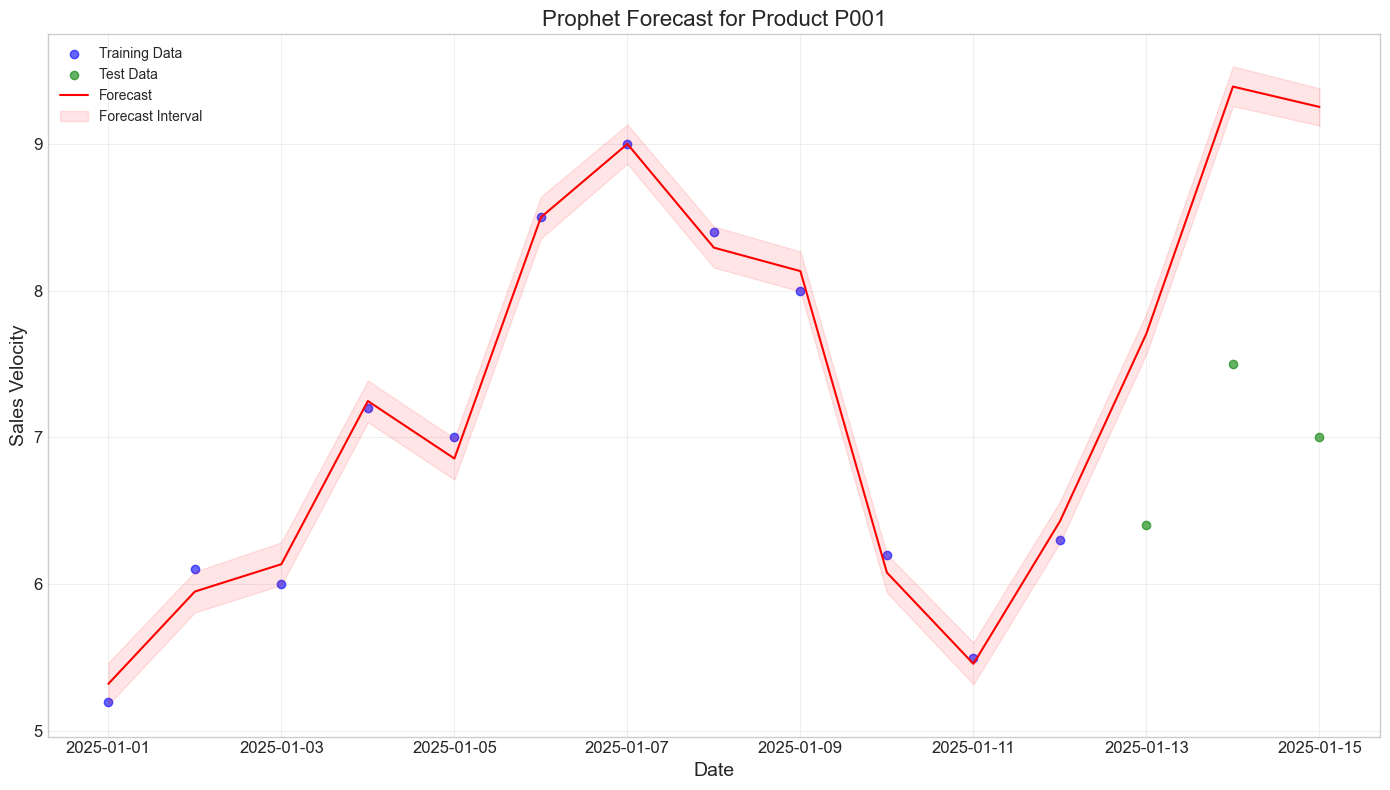

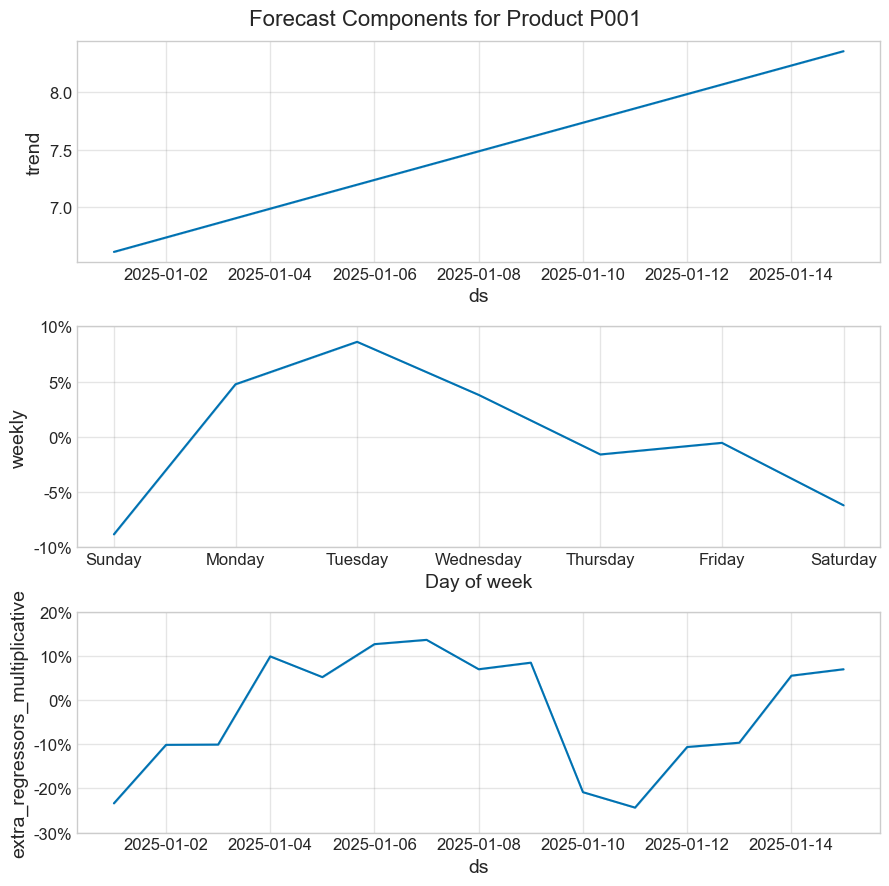

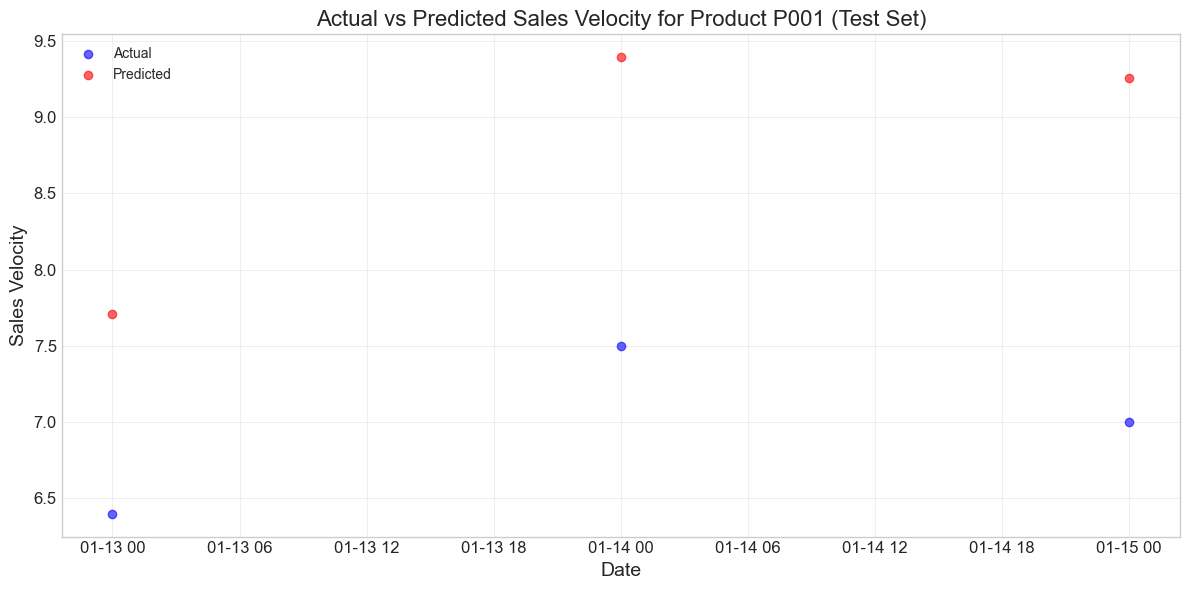

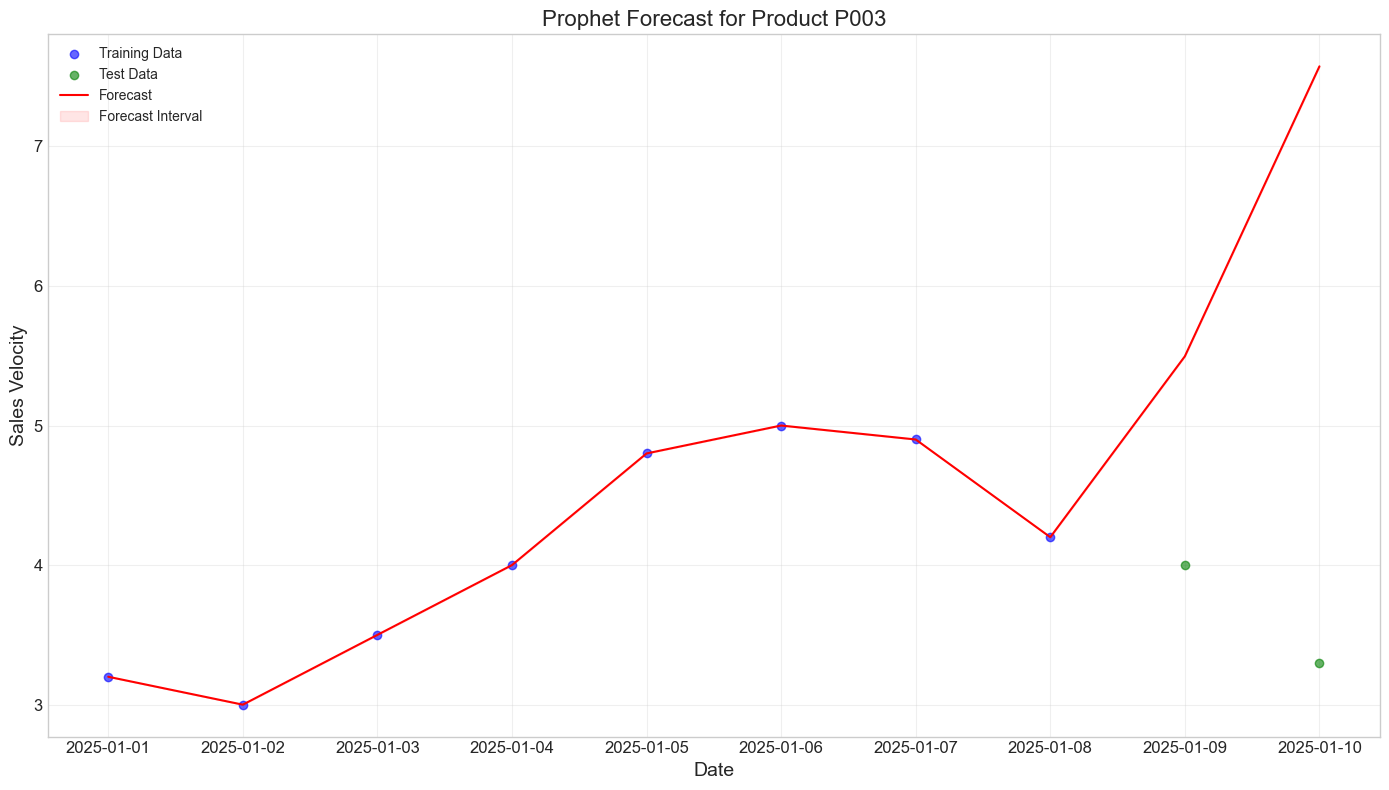

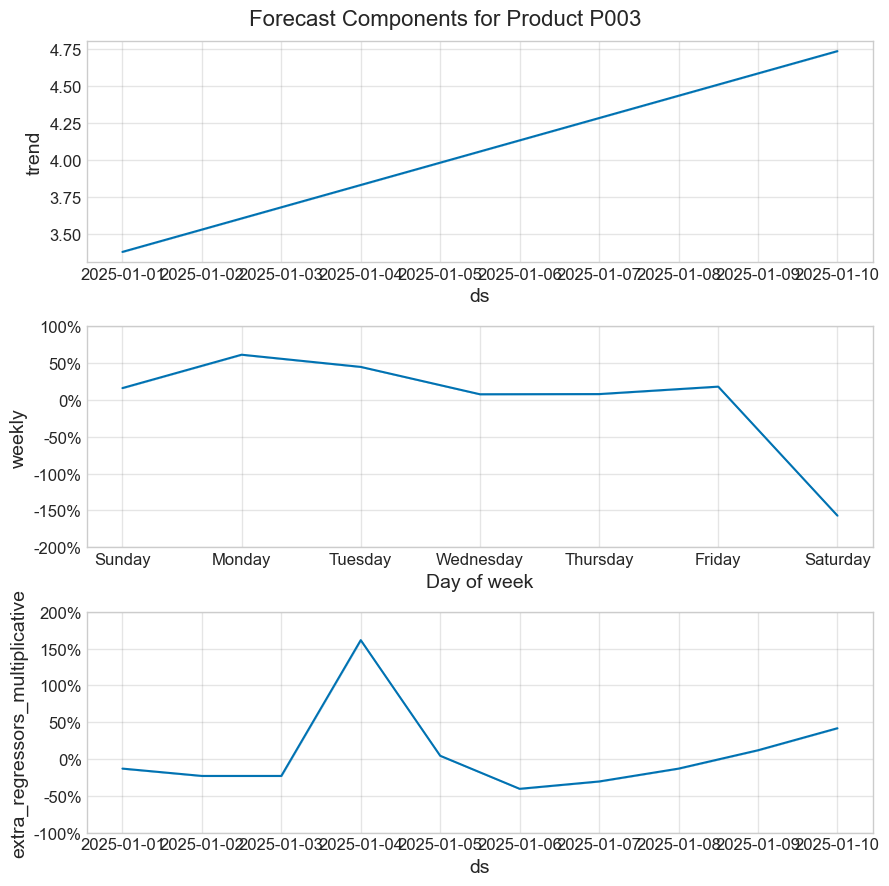

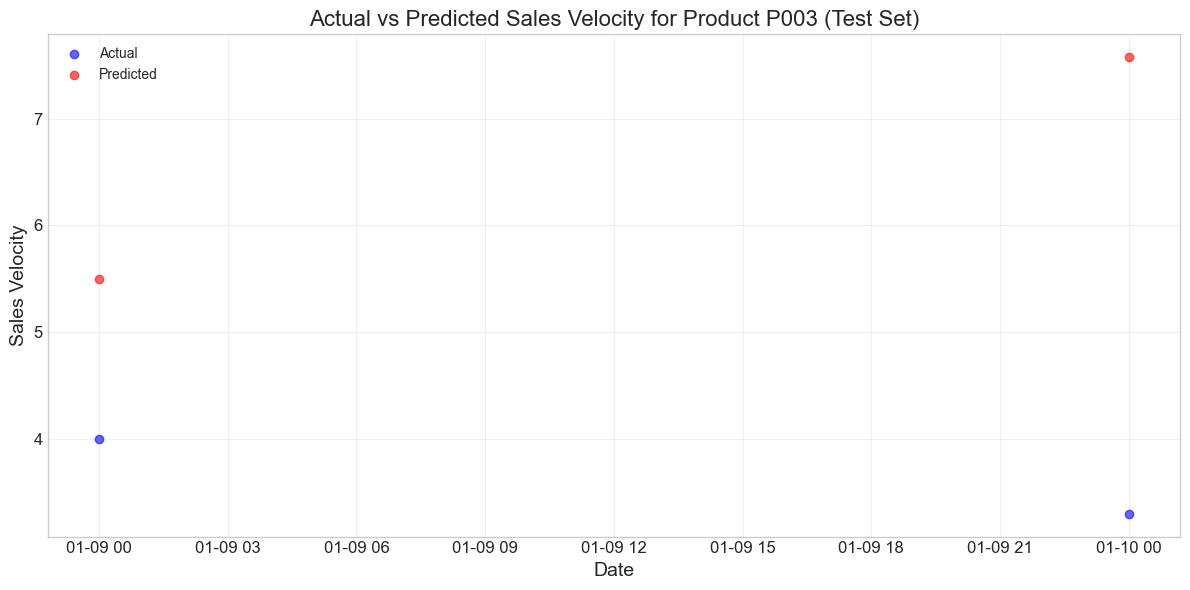

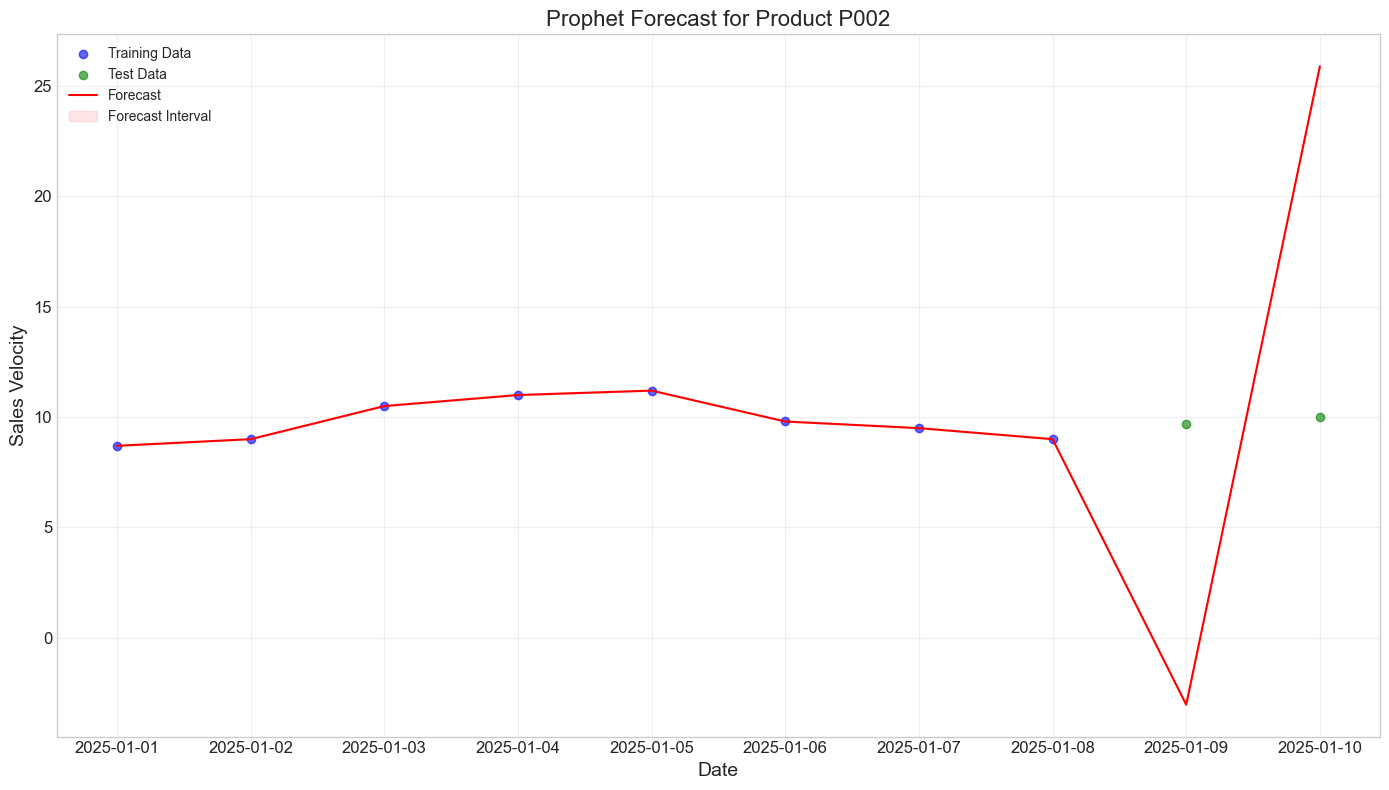

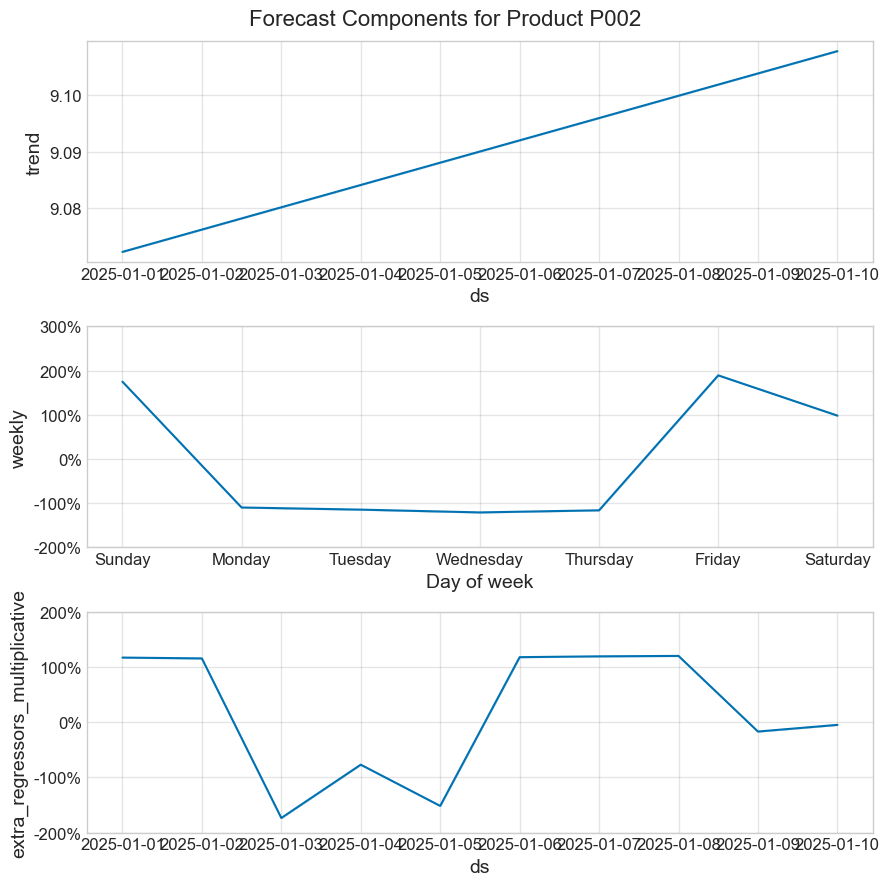

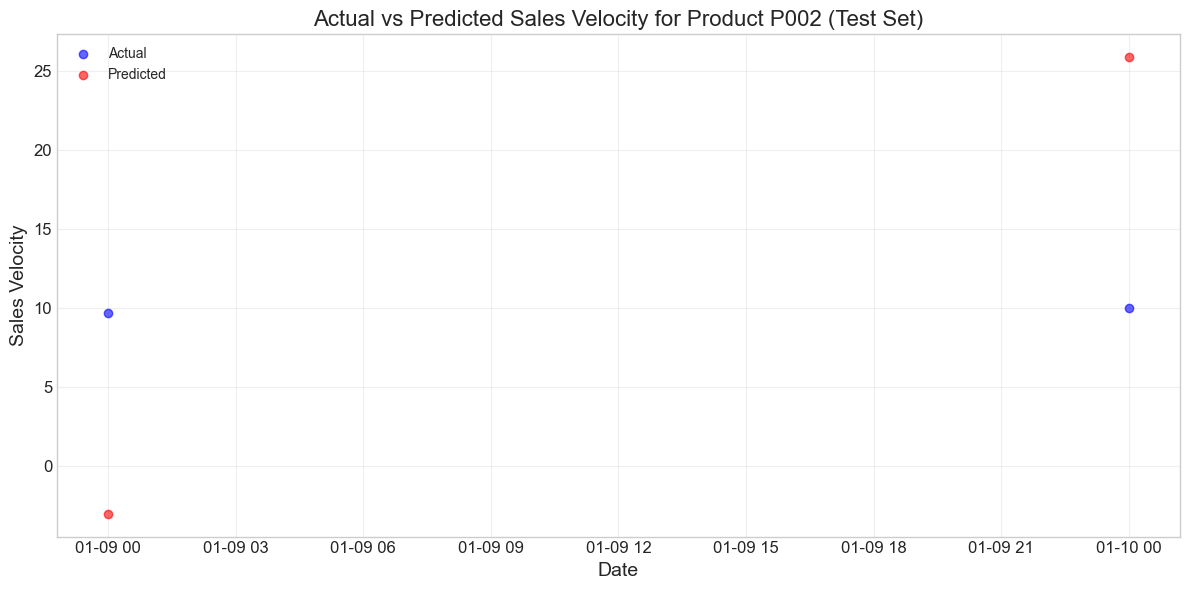

In [7]:
# Visualize forecasts
for product_id, result in prophet_results.items():
    model = result['model']
    forecast = result['forecast']
    train_df = result['train']
    test_df = result['test']
    
    # Plot forecast
    fig = plt.figure(figsize=(14, 8))
    
    # Plot training data
    plt.scatter(train_df['ds'], train_df['y'], color='blue', label='Training Data', alpha=0.6)
    
    # Plot test data
    plt.scatter(test_df['ds'], test_df['y'], color='green', label='Test Data', alpha=0.6)
    
    # Plot forecast
    plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='red', alpha=0.1, label='Forecast Interval')
    
    plt.title(f'Prophet Forecast for Product {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Sales Velocity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot components
    fig = model.plot_components(forecast)
    plt.suptitle(f'Forecast Components for Product {product_id}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted for test set
    plt.figure(figsize=(12, 6))
    plt.scatter(test_df['ds'], test_df['y'], color='blue', label='Actual', alpha=0.6)
    plt.scatter(test_df['ds'], result['predictions'], color='red', label='Predicted', alpha=0.6)
    plt.title(f'Actual vs Predicted Sales Velocity for Product {product_id} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales Velocity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 3. LSTM Deep Learning Model

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [8]:
# Function to prepare data for LSTM model
def prepare_lstm_data(df, target_col='sales_velocity', sequence_length=3, test_size=0.2):
    """
    Prepare data for LSTM model by creating sequences.
    
    Args:
        df: DataFrame containing time series data
        target_col: Column name of the target variable
        sequence_length: Number of previous time steps to use as input features
        test_size: Proportion of data to use for testing
        
    Returns:
        Dictionary containing prepared data and scalers
    """
    data = df.copy()
    
    # Select relevant numerical columns (exclude date and categorical columns)
    numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Standardize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Scale features
    data_scaled = data[numerical_cols].copy()
    feature_cols = [col for col in numerical_cols if col != target_col]
    
    data_scaled[feature_cols] = scaler_X.fit_transform(data[feature_cols])
    data_scaled[target_col] = scaler_y.fit_transform(data[[target_col]])
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - sequence_length):
        X.append(data_scaled[feature_cols].values[i:(i + sequence_length)])
        y.append(data_scaled[target_col].values[i + sequence_length])
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols,
        'sequence_length': sequence_length
    }

# Prepare LSTM data for each product
lstm_data = {}
for product_id, product_df in product_dataframes.items():
    print(f"\nPreparing LSTM data for Product {product_id}")
    lstm_data[product_id] = prepare_lstm_data(product_df, sequence_length=5)


Preparing LSTM data for Product P001
X_train shape: (8, 5, 22)
X_test shape: (2, 5, 22)

Preparing LSTM data for Product P003
X_train shape: (4, 5, 22)
X_test shape: (1, 5, 22)

Preparing LSTM data for Product P002
X_train shape: (4, 5, 22)
X_test shape: (1, 5, 22)


In [9]:
# Function to build and train LSTM model
def build_lstm_model(data, product_id):
    """
    Build and train LSTM model.
    
    Args:
        data: Dictionary containing prepared data and scalers
        product_id: Product ID
        
    Returns:
        Dictionary containing model, history, and metrics
    """
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # Get input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    print(f"\nBuilding LSTM model for Product {product_id}")
    print(f"Input shape: {input_shape}")
    
    # Define model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Testing Loss: {test_loss:.4f}")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Inverse transform predictions
    y_train_pred_inv = data['scaler_y'].inverse_transform(y_train_pred)
    y_test_pred_inv = data['scaler_y'].inverse_transform(y_test_pred)
    y_train_inv = data['scaler_y'].inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = data['scaler_y'].inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
    
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    
    return {
        'model': model,
        'history': history,
        'train_pred': y_train_pred_inv,
        'test_pred': y_test_pred_inv,
        'train_actual': y_train_inv,
        'test_actual': y_test_inv,
        'metrics': {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse
        }
    }

# Build LSTM models for each product
lstm_results = {}
for product_id, data in lstm_data.items():
    lstm_results[product_id] = build_lstm_model(data, product_id)


Building LSTM model for Product P001
Input shape: (5, 22)
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 1.7600 - val_loss: 0.3303
Epoch 2/100
1/1 [==============================] - 0s 74ms/step - loss: 1.6398 - val_loss: 0.3035
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 1.5498 - val_loss: 0.2780
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 1.3814 - val_loss: 0.2535
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 1.3187 - val_loss: 0.2304
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 1.2416 - val_loss: 0.2080
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 1.0485 - val_loss: 0.1862
Epoch 8/100
1/1 [==============================] - 0s 36ms/step - loss: 1.0457 - val_loss: 0.1654
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 0.8507 - val_loss: 0.1454
Epoch 10/100
1/1 [==============================] - 0s 39ms/s

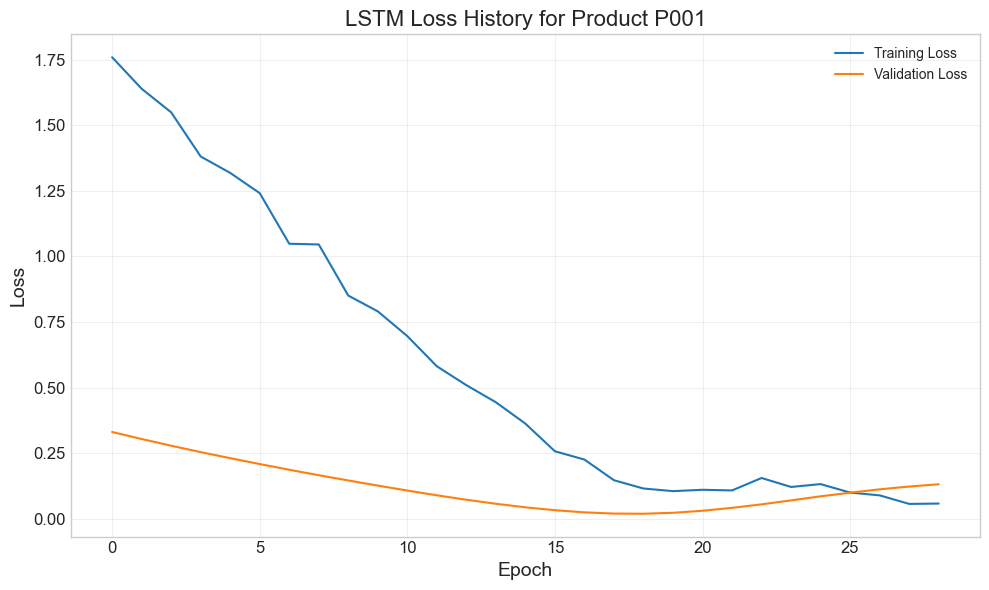

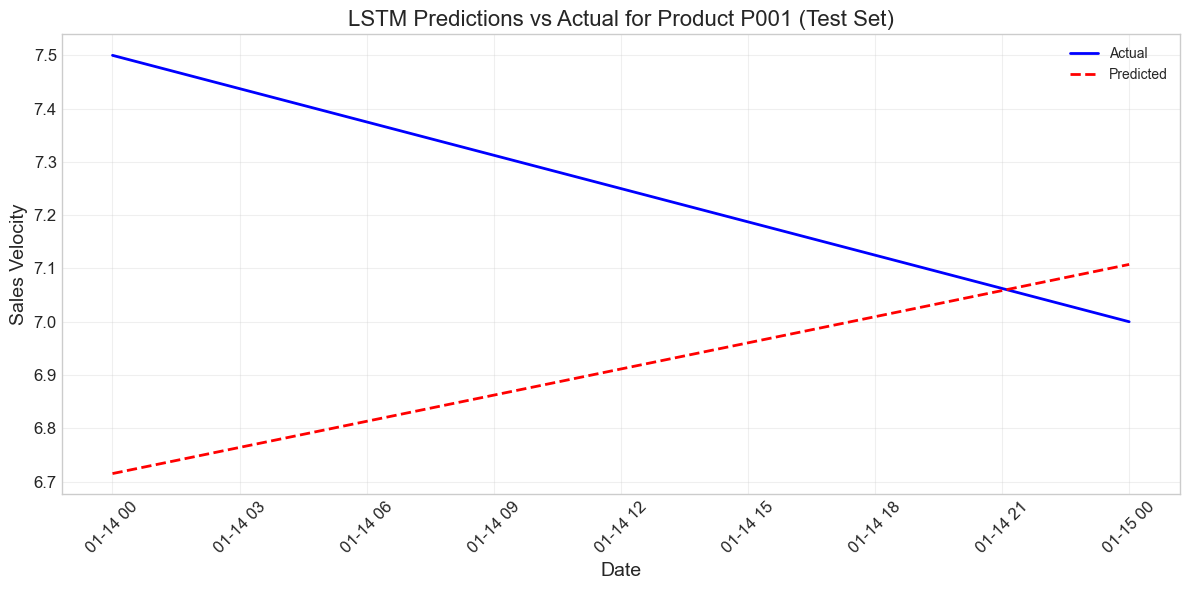

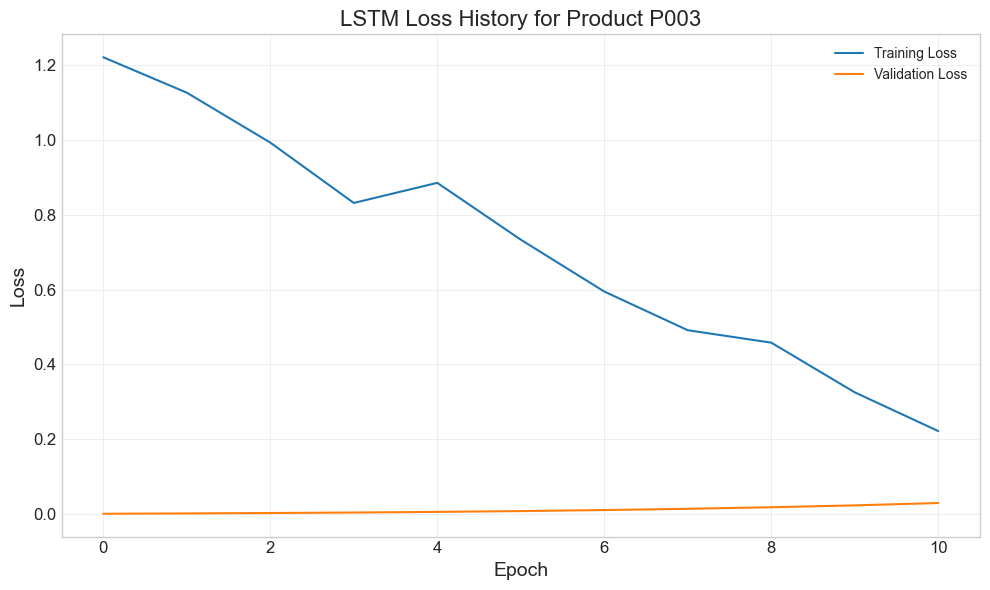

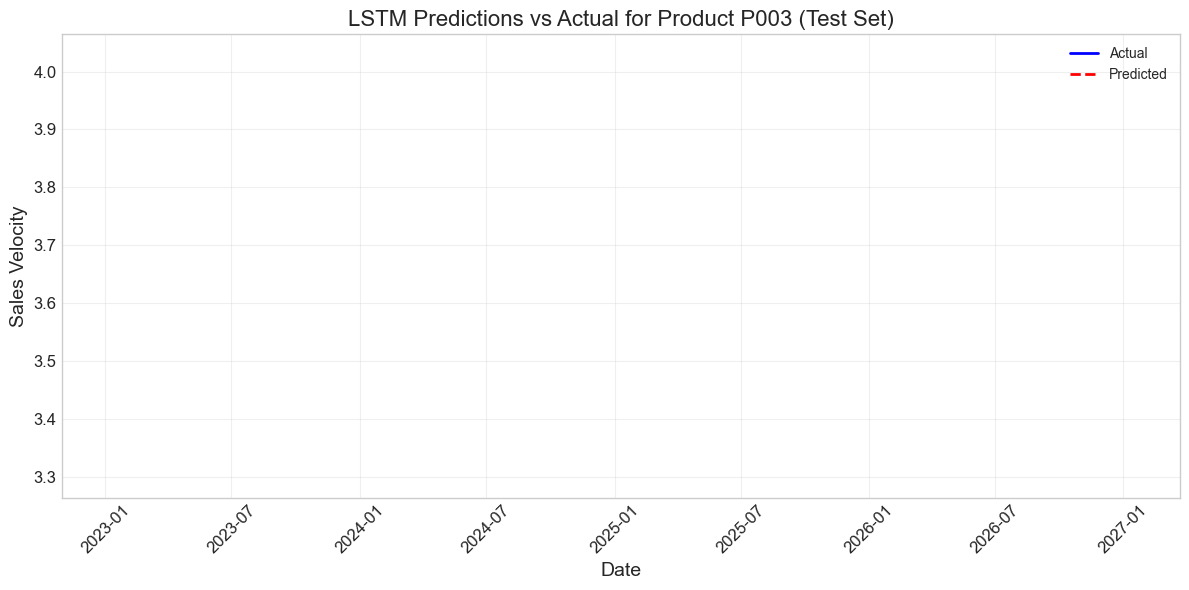

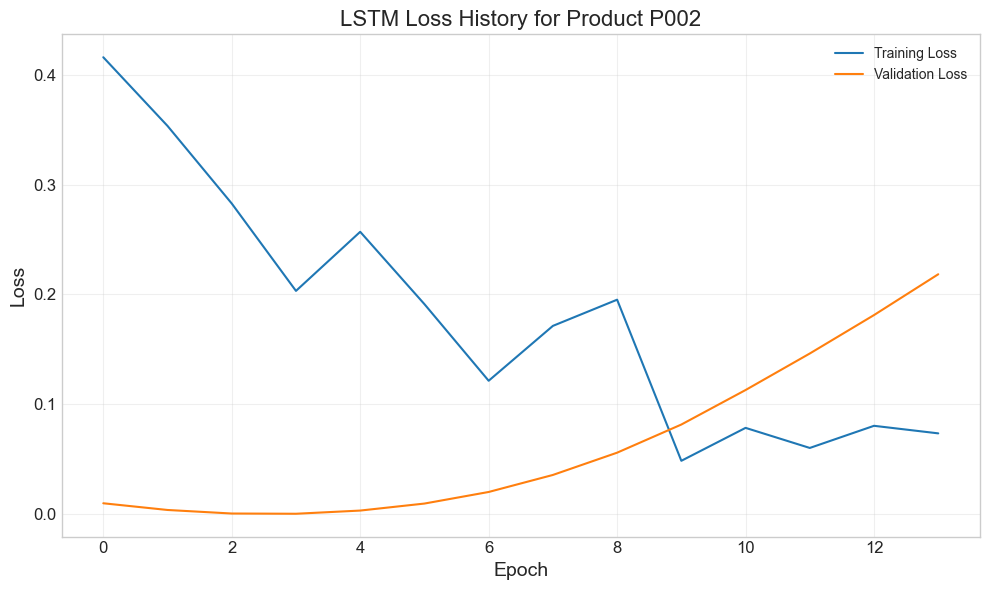

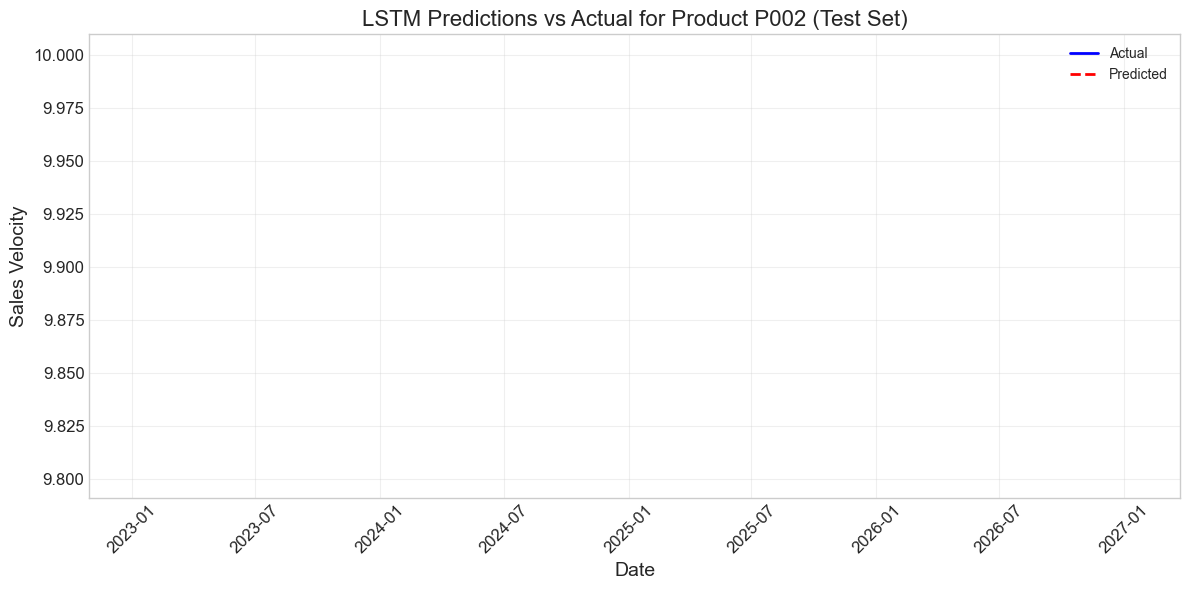

In [10]:
# Visualize LSTM results
for product_id, result in lstm_results.items():
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(result['history'].history['loss'], label='Training Loss')
    plt.plot(result['history'].history['val_loss'], label='Validation Loss')
    plt.title(f'LSTM Loss History for Product {product_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actual for test set
    plt.figure(figsize=(12, 6))
    
    # Get corresponding dates for test set
    product_df = product_dataframes[product_id]
    sequence_length = lstm_data[product_id]['sequence_length']
    test_size = len(lstm_data[product_id]['y_test'])
    test_dates = product_df['date'].iloc[-(test_size):].reset_index(drop=True)
    
    plt.plot(test_dates, result['test_actual'], 'b-', label='Actual', linewidth=2)
    plt.plot(test_dates, result['test_pred'], 'r--', label='Predicted', linewidth=2)
    
    plt.title(f'LSTM Predictions vs Actual for Product {product_id} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales Velocity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 4. XGBoost Time Series Forecasting

XGBoost is a powerful gradient boosting algorithm that can be adapted for time series forecasting.

In [11]:
# Function to prepare data for XGBoost model
def prepare_xgboost_data(df, target_col='sales_velocity', test_size=0.2):
    """
    Prepare data for XGBoost model.
    
    Args:
        df: DataFrame containing time series data
        target_col: Column name of the target variable
        test_size: Proportion of data to use for testing
        
    Returns:
        Dictionary containing prepared data
    """
    data = df.copy()
    
    # Create lag features
    for lag in range(1, 4):  # Create 3 lag features
        data[f'sales_lag_{lag}'] = data['sales_velocity'].shift(lag)
    
    # Create rolling statistics
    data['rolling_mean_3'] = data['sales_velocity'].rolling(window=3).mean()
    data['rolling_std_3'] = data['sales_velocity'].rolling(window=3).std()
    
    # Drop rows with NaN values (due to lag/rolling features)
    data = data.dropna()
    
    # Select features and target
    feature_cols = [col for col in data.columns if col != target_col and col != 'date']
    X = data[feature_cols]
    y = data[target_col]
    
    # Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Get corresponding dates
    train_dates = data['date'].iloc[:train_size].reset_index(drop=True)
    test_dates = data['date'].iloc[train_size:].reset_index(drop=True)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'feature_cols': feature_cols
    }

# Prepare XGBoost data for each product
xgb_data = {}
for product_id, product_df in product_dataframes.items():
    print(f"\nPreparing XGBoost data for Product {product_id}")
    xgb_data[product_id] = prepare_xgboost_data(product_df)


Preparing XGBoost data for Product P001
X_train shape: (9, 30)
X_test shape: (3, 30)

Preparing XGBoost data for Product P003
X_train shape: (5, 30)
X_test shape: (2, 30)

Preparing XGBoost data for Product P002
X_train shape: (5, 30)
X_test shape: (2, 30)


In [13]:
# Function to build and train XGBoost model
def build_xgboost_model(data, product_id):
    """
    Build and train XGBoost model.
    
    Args:
        data: Dictionary containing prepared data
        product_id: Product ID
        
    Returns:
        Dictionary containing model, predictions, and metrics
    """
    X_train = data['X_train'].copy()
    X_test = data['X_test'].copy()
    y_train = data['y_train']
    y_test = data['y_test']

    # Convert object columns to category codes and UInt32 to int
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes
        elif str(X_train[col].dtype).startswith('UInt'):
            X_train[col] = X_train[col].astype(int)
            X_test[col] = X_test[col].astype(int)
    
    print(f"\nTraining XGBoost model for Product {product_id}")
    
    # Define model parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_estimators': 100
    }
    
    # Train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.2f}")
    
    return {
        'model': model,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred,
        'metrics': {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        },
        'feature_importance': model.feature_importances_,
        'feature_names': data['feature_cols']
    }

# Build XGBoost models for each product
xgb_results = {}
for product_id, data in xgb_data.items():
    xgb_results[product_id] = build_xgboost_model(data, product_id)


Training XGBoost model for Product P001
Train MAE: 0.14
Train RMSE: 0.23
Test MAE: 0.66
Test RMSE: 0.72
Test R²: -1.56

Training XGBoost model for Product P003
Train MAE: 0.09
Train RMSE: 0.12
Test MAE: 0.51
Test RMSE: 0.62
Test R²: -2.09

Training XGBoost model for Product P002
Train MAE: 0.25
Train RMSE: 0.32
Test MAE: 0.39
Test RMSE: 0.39
Test R²: -5.92


In [ ]:
# Visualize XGBoost results
for product_id, result in xgb_results.items():
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(result['feature_importance'])
    plt.barh(range(len(sorted_idx)), result['feature_importance'][sorted_idx])
    plt.yticks(range(len(sorted_idx)), [result['feature_names'][i] for i in sorted_idx])
    plt.title(f'Feature Importance for Product {product_id}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actual for test set
    plt.figure(figsize=(12, 6))
    test_dates = xgb_data[product_id]['test_dates']
    
    plt.plot(test_dates, xgb_data[product_id]['y_test'], 'b-', label='Actual', linewidth=2)
    plt.plot(test_dates, result['test_pred'], 'r--', label='Predicted', linewidth=2)
    
    plt.title(f'XGBoost Predictions vs Actual for Product {product_id} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales Velocity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()